<a name='1'></a>
## 1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- ```vertexmodelpy``` is the name of the vertex model package we will be working with.


<a name='1-1'></a>
### 1.1 - Importing

Initialize an random number geberator instance with ```np.random.default_rng```.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time


import numpy as np
import math
# import igraph as ig

from vertexmodelpy.basic_topology import *

from vertexmodelpy.triangulation import Triangulation
from vertexmodelpy.minimizer import TissueMinimizer
from vertexmodelpy.energetics import tissue_energy,tissue_gradient
from vertexmodelpy.topology_triggers import (resolve_high_order_vertices,
                                        t1_able_edges, generic_t1_rearrangement)

from vertexmodelpy.utilities import find_face_vertices_faster,get_face_colors
from vertexmodelpy.tissue_generation import (convert_to_tissue_class,generate_hexagonal_disk,
                                             generate_honeycomb_patch)

from vertexmodelpy.coarse_graining_functions import *


from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import PolyCollection,LineCollection


<a name='1-2'></a>
### 1.2 - Random Number generator initialization

Initialize an random number geberator instance with ```np.random.default_rng```.

In [2]:
seed = 12345
rng = np.random.default_rng(seed)

<a name='2'></a>
## 2 - Halfedge Data Structure

The ```Tissue``` object is the main structure we will be working with. TWe heavily rely on the [halfedge](https://doc.cgal.org/latest/HalfedgeDS/index.html) data structure to encode the underlying network topology of the tissue. With halfedges each references a vertex it point away from as well as a vertex it points to. Additionally, each edge is associated to a single polygonal mesh which is useful in cases where we must deal with a pair of adjacent faces. The halfedge data structure can be easily understood with an schematic. we have a pair of half edges $e_1$ and $e_2$ associated respectively with the pair of adjacent faces $f_1$ and $f_2$. We refer to edges $e_1$ and $e_2$ as pair of "conjugate" edges. In this diagram the edge $e_1$ ($e_2$) points away from $v_1$ ($v_2$) and points to $v_2$ ($v_1$). Each halfedge has a neighbor with respect to the anti-clockwise direction which we denote as the "left" edge. In this case both $e_3$ and $e_4$ are respectively the left edges of $e_1$ and $e_2$. Notice that the left edges are still associated with the same polygonal face which for the halfedges $e_3$ and $e_4$ are faces $f_1$ and $f_2$ respectively.

Notice that this data structure is purely combinatorial and does not rely at all on the geometrical data of the ```Tissue``` object. This is particularly useful for introducing topological changes within the network structure of the tissue which often consist of "surgeries" in which the conjugate and left edges of a given halfedge are redefined.

<center><img src="halfedge.png" style="width:300;height:300;">
<caption><center> <u> <font color='red'> <b>Figure 1</b> </u><font color='red'>  : Halfedge data structure <br> </center></caption>

<a name='3'></a>
## 3 - Tissue Generation and Visualization

<a name='3-1'></a>
### 3.2 - Tissue Generation

Some convenience functions are provided to generate simple geometries such as disks composed of cells or rectangular configuration. The function ```convert_to_tissue_class(tissue_generating_func,*args,**kwargs)``` takes a tissue generating function named as ```tissue_generating_func``` that can optionally take both ```args``` and ```kwargs```. Its role is to define the vertex positions, the edge end points, and the list of vertex indices composing each polygonal face. This data structures are processed under the hood to generate a list of pandas ```DataFrames``` encoding the informations about the vertices, edges, and faces.

In [350]:
N_points_perifery = 100 # Number of points located at the boundary of the disk as well as a
rad = 1.0

tissue = convert_to_tissue_class(generate_hexagonal_disk,N_points_perifery,radius=rad)


<a name='3-2'></a>
### 3.2 - Tissue Visualization

Once a ```Tissue``` object has been created we can visualize it. To do that we can extract the vertex coordinates composing the corners of each polygonal face. This can efficiently done with the help ```find_face_vertices_faster``` which is suitable for retrieving the vertex positions of the entire tissue. We first create a quick convenience function for easily plotting the tissue.

In [351]:
def plot_tissue(tissue,color_by='',same_face_color='green'):
    # We calculate the vertex positions composing the corners of each face
    poly_verts = find_face_vertices_faster(tissue)
    
    # We can color the faces with respect to their number of sides 'sum_sides' or by 'area'. 
    # This will be eventually generalized to include other coloring options
    # The color scheme can be changed. Try foe example viridis, magma, Dark2, ...
    
    if color_by != '':
        facecolors = get_face_colors(tissue,color_by=color_by,color_map=cm.viridis)
    else:
        facecolors = same_face_color
        

    fig, ax = plt.subplots(1, frameon = True, dpi=600,figsize=(1.,1.))
    ax.set_aspect('equal')

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # With poly_verts we create a PolyCollection and add it to the plot.
    coll = PolyCollection(poly_verts, edgecolors='black',facecolors=facecolors,linewidths=0.1)


    ax.add_collection(coll)
    ax.autoscale_view()


    plt.show()
    
    return    
    

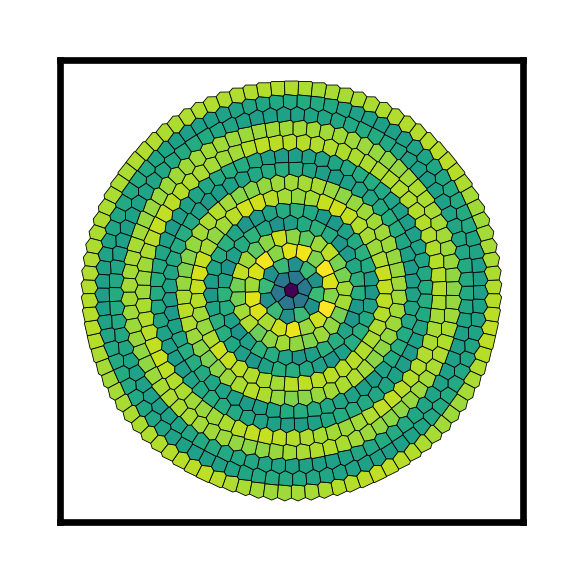

In [352]:
plot_tissue(tissue,color_by='area')

We can retrieve during any given time the ```DataStructures``` composing the object ```tissue``` as ```tissue.vert_df```, ```tissue.edge_df```, or ```tissue.face_df```. The ```edge_df``` attribute gives us information about the halfedges composing the tissue object and contains the  vertex ID's that each halfedge point away and towards, whether the haldedge has a conjugate halfedge or not, left neighbor (also right neighbor!), the face it belongs to, etc.

In [353]:
tissue.edge_df
# export as csv 
tissue.edge_df.to_csv('tissue_edges.csv',index=False)

tissue.face_df
# export as csv 
tissue.face_df.to_csv('tissue_face.csv',index=False)

tissue.vert_df
# export as csv 
tissue.vert_df.to_csv('tissue_vert.csv',index=False)


<a name='4'></a>
## 4 - Energy Minimization

Once we are happy with the starting topology and geometry of our ```Tissue``` object, we can call minimize its energy with respect to the 2D vertex model (VM) energetics originally introduced by [Farhadifar et. al.](https://www.sciencedirect.com/science/article/pii/S0960982207023342). In its simplest, non-dimensionalized form, for cells with unit preferred area, the energy function is given by:

$E=\frac{1}{2}\sum_{\alpha}\left[\left(A^{\alpha}-1\right)^2+\Gamma\left(P^{\alpha}-P_0\right)^2\right]+\frac{\Lambda}{2}\sum_{b\in\partial S}\ell^{b}, $

where superscripts $\alpha$ and $b$ denote cell and junction identity respectively. $\Gamma$ and $\Lambda$ are the perimeter stiffness and line tension of cellular junctions respectively, and $\ell^b$ is a junction length. The term $P_0=-\Lambda/2\Gamma$ is a preferred perimeter. The third term, only present in tissue patches, $S$, with non-compact topology, acting on cellular junctions at the boundary of the patch, $\partial S$, behaves as a source of line tension.

We create a ```TissueMinimizer``` object which can take as parameters the energy function of the tissue as well as its gradient. We only provide the standard VM energetics but other energy functions and gradients can be passed to the ```TissueMinimizer``` class which heavily relies on the ```scipy.optimize.minimize``` module to carry out energy minimizations. We calculate the VM energetics and gradients with the functions ```tissue_energy``` and ```tissue_gradient```. We can additionally specify the minimization method or tolerance for early stopping. Refer to the [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) for further details about the minimization algorithms.

In [360]:
# A TissueMinimizer instance is created

energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)


Once the ```TissueMinimizer``` object has been created, the energy of the ```Tissue``` object can be minimized by calling the ```find_energy_min()``` method. By default, the energy minimization will collapse faces or edges once they go below a certain treshhold which are given by the ```t1_cutoff``` and ```t2_cutoff``` attributes of the ```Tissue``` object.


In [361]:
# We minimize the energy of the tissue

energy_solver.find_energy_min()

We can then visualize our tissue after energy minimization to see how it was affected by the imposed preferred geometry which in our case is controlled by the ```line_tension``` and ```contractility``` parameters.

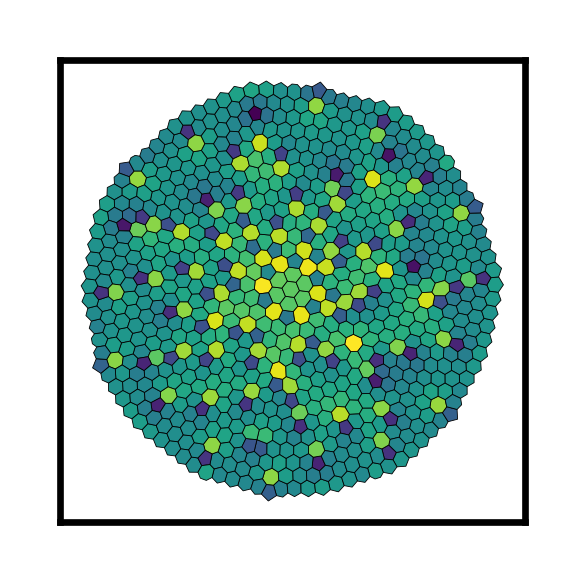

In [362]:
plot_tissue(tissue,color_by='area')

In [60]:
tissue.edge_df

id  v_out_id  v_in_id  is_interior    length  line_tension  left_dbond  \
0      0        17       15         True  0.499892          0.12           1   
1      1        15       13        False  0.465204          0.12           2   
2      2        13       14        False  0.465201          0.12           3   
3      3        14       12        False  0.465206          0.12           4   
4      4        12       16         True  0.462125          0.12           5   
..   ...       ...      ...          ...       ...           ...         ...   
228  228       100       66         True  0.432408          0.12         102   
229  229       101       68         True  0.418502          0.12          84   
230  230       101       67         True  0.445736          0.12         108   
231  231       101      100         True  0.580964          0.12         227   
232  232       100      101         True  0.580964          0.12         229   

     right_dbond  conj_dbond  dbond_face  
0              5          11           0  
1              0          -1           0  
2              1          -1           0  
3              2          -1           0  
4              3          81           0  
..           ...         ...         ...  
228          107          86          17  
229          232         113          38  
230          113          89          18  
231           89         232          14  
232           86         231          38  

[233 rows x 10 columns]

In [363]:
tissue.edge_df
# export as csv 
tissue.edge_df.to_csv('tissue_edges_EM1.csv',index=False)

tissue.face_df
# export as csv 
tissue.face_df.to_csv('tissue_face_EM1.csv',index=False)

tissue.vert_df
# export as csv 
tissue.vert_df.to_csv('tissue_vert_EM1.csv',index=False)


<a name='4'></a>
## 4 - Topological Changes

Let's discuss now the capabilities we have to modify the network topology of the tissue. We will show here how to perform an edge collapse, vertex splitting ,T1 rearrangements, cell collapse, as well as cell divisions.

<a name='4-1'></a>
### 4.1 - Edge Collapse and Vertex Splitting

The simplest topological change. It takes an edge of the network and collapses to a vertex. To collapse a single edge we only need to specify its halfedge ID. For internal halfedges this also collapses the conjugate halfedge so that the topology remains well defined after the change. Let's randomly choose a few internal edges!

In [375]:
edge_list = tissue.edge_df.loc[tissue.edge_df['is_interior'] == True,'id'].sample(n=100,random_state=1).values

edge_list

array([4279, 3172, 2139, 3862, 2721, 1908, 1894, 3188, 4362,  865, 1107,
       2526,  513, 4157, 3482, 4076, 1455, 1205, 3209, 2596, 4168, 2020,
       1706, 1165, 1915, 4050, 4170, 4049, 2693, 4451, 4183, 4290,  498,
       1457,  909,  743, 1105, 3559,  116, 1726, 4372, 1310, 1981,  761,
       3281, 3131, 4144, 3624, 1598,   41, 3591, 3386, 3685, 3010, 2878,
        881, 2732, 3384, 2292,  147, 3797, 1300, 3255, 4103, 4054, 2969,
       3722, 1270, 3820, 1784,  952, 4047,  335,  873, 2074,  558, 2562,
       2556, 3878, 2564, 2814, 3753,  961, 2613, 1425, 1248,  605, 3882,
       1359, 1543, 3280, 3871,  312, 1773, 2888,  620, 3528, 1275, 2582,
       2190])

We can then collapase this edges. Notice that in general we need to make sure that a pair of conjugate edges are not part of this list since otherwise this would throw an error.

In [376]:
for edge_id in edge_list:
    collapse_edge(tissue,edge_id)

Let's minimize the energy and plot. This time let's color the cells by their number of sides.

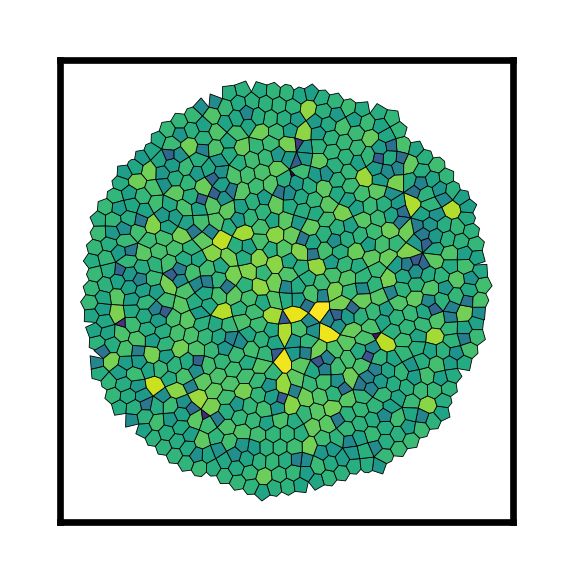

In [377]:
energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)

energy_solver.find_energy_min()

plot_tissue(tissue,color_by='area')

In [378]:
tissue.edge_df
# export as csv 
tissue.edge_df.to_csv('tissue_edges_edge_collapse.csv',index=False)

tissue.face_df
# export as csv 
tissue.face_df.to_csv('tissue_face_edge_collapse.csv',index=False)

tissue.vert_df
# export as csv 
tissue.vert_df.to_csv('tissue_vert_edge_collapse.csv',index=False)

We can do something similar for boundary halfedges which only requires us to change the way we query the ```edge_df``` ```DataFrame```.

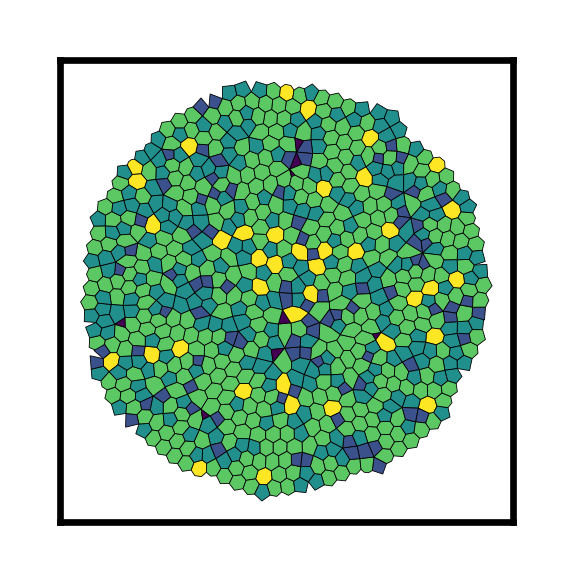

In [379]:
edge_list_boundary = tissue.edge_df.loc[tissue.edge_df['is_interior'] == False,'id'].sample(n=100,random_state=1).values

edge_list_boundary

plot_tissue(tissue,color_by='num_sides')

In [380]:
for edge_id in edge_list_boundary:
    collapse_edge(tissue,edge_id)

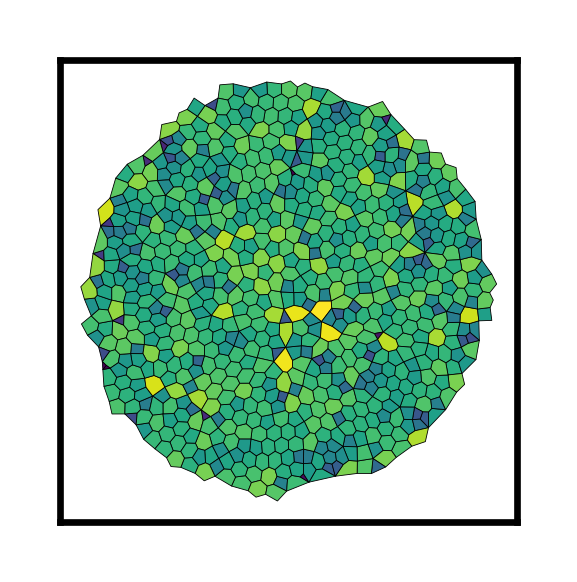

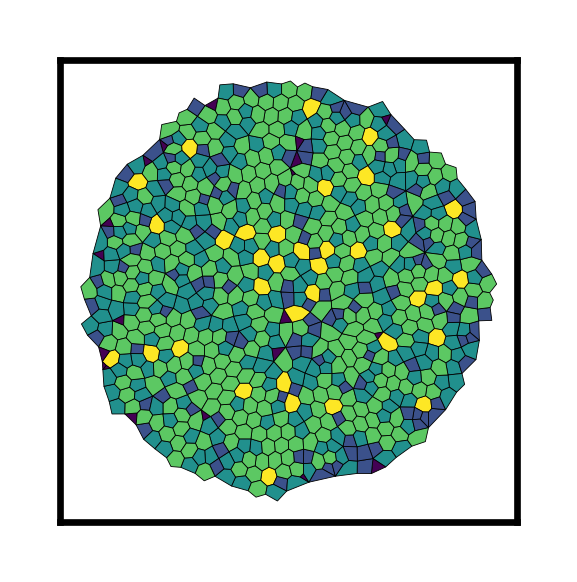

In [381]:
energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)

energy_solver.find_energy_min()

plot_tissue(tissue,color_by='area')
plot_tissue(tissue,color_by='num_sides')

tissue.edge_df
# export as csv 
tissue.edge_df.to_csv('tissue_edges_before_round1.csv',index=False)

tissue.face_df
# export as csv 
tissue.face_df.to_csv('tissue_face_before_round1.csv',index=False)

tissue.vert_df
# export as csv 
tissue.vert_df.to_csv('tissue_vert_before_round1.csv',index=False)

We can take advantage of endge collapse at the boundary and push it even further. The function ```round_off_boundary```  makes each cell at the boundary only have a single boundary halfedge. This function takes a ```Tissue``` object as an argument.

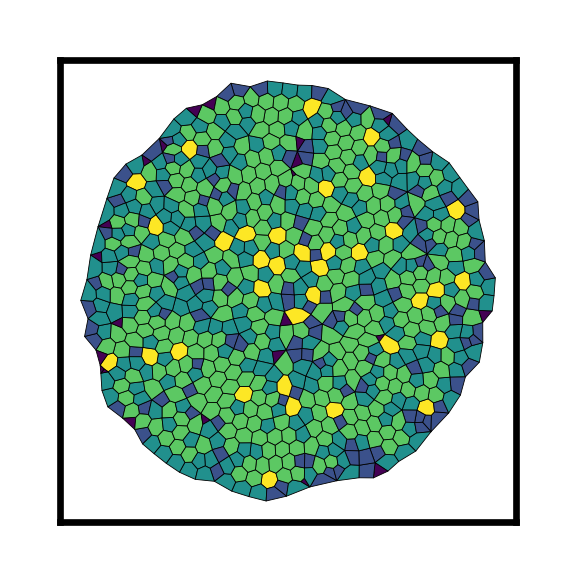

In [383]:
round_off_boundary(tissue)

energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)

energy_solver.find_energy_min()

plot_tissue(tissue,color_by='num_sides')

tissue.edge_df
# export as csv 
tissue.edge_df.to_csv('tissue_edges_after_round1.csv',index=False)

tissue.face_df
# export as csv 
tissue.face_df.to_csv('tissue_face_after_round1.csv',index=False)

tissue.vert_df
# export as csv 
tissue.vert_df.to_csv('tissue_vert_after_round1.csv',index=False)

Notice that we have some vertices that share more than 3 vertices. In certain situations it might be energitically favorable to split a vertex into two vertices which effectively created a single or a pair of halfedges depending of whether or not the vertex is internal or at the boundary. This can be internally done with the function ```resolve_high_order_vertices``` which takes a ```Tissue``` object as an argument.

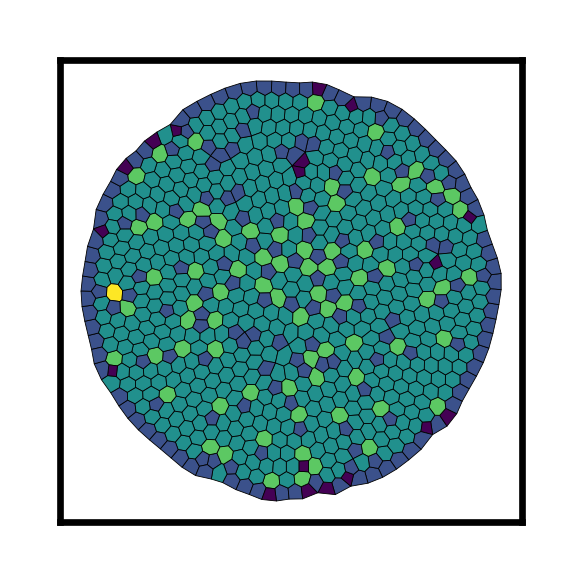

In [386]:
resolve_high_order_vertices(tissue)

energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)

energy_solver.find_energy_min()

plot_tissue(tissue,color_by='num_sides')

tissue.edge_df
# export as csv 
tissue.edge_df.to_csv('tissue_edges_rhov1.csv',index=False)

tissue.face_df
# export as csv 
tissue.face_df.to_csv('tissue_face_rhov1.csv',index=False)

tissue.vert_df
# export as csv 
tissue.vert_df.to_csv('tissue_vert_rhov1.csv',index=False)

Notice that a minimization is usually done after modifying the topology of the tissue. This ensures that the tissue always finds itself in a state of mechanical equilibrium.

<a name='4-2'></a>
### 4.2 - T1 rearrangements

The simplest version of a T1 transition or rearrangement takes a group of 4 cells of which two of them share a bond and shuffles them in a way that the cells that were not touching each other before are now neighbors. This is better explain with an schematic. In the figure below we observe that cells 3 and 4 are originally neighboring cells while 1 and 2 are not. After the T1 transition 3 and 4 are no longer neighbors but 1 and 2 are. 

<center><img src="t1_event.png" style="width:5;height:5;">
<caption><center> <u> <font color='red'> <b>Figure 2</b> </u><font color='red'>  : T1 transition. <br> </center></caption>

Let's generate another tissue from scratch so it is easier to see how the T1 events act on it. We focus on this case on a honeybomb lattice rectangle of dimensions $L_x$ and $L_y$. For this we will use the function ```generate_honeycomb_patch``` which is passed to ```convert_to_tissue_class```.

In [79]:
Lx, Ly = 6, 6 # Dimensions of hexagonal box
orientation = 'x' # Try to use 'y' instead to have two of the sides of the hexagon parallel to the x axis.

tissue = convert_to_tissue_class(generate_honeycomb_patch,Lx,Ly,rotation=orientation)

# generate_honeycomb_patch(Lx=10, Ly=10,rotation='x')

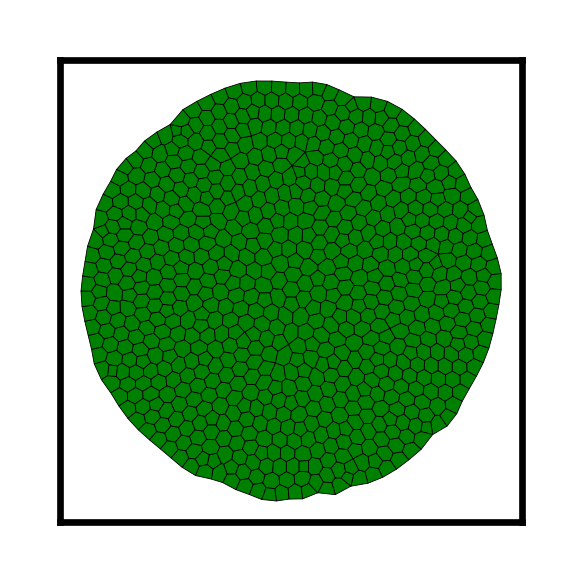

In [387]:
plot_tissue(tissue,color_by='',same_face_color='green')

We can use the function ```t1_able_edges``` to find a list of halfedges that can go undergo a T1 transition. As we will see below, special care needs to be taken with halfedges located at the boundary. the argument ```t1_type``` takes into account 3 cases: ```interior_t1```, ```interior_to_boundary_t1```, and ```boundary_t1```. Let's look at these moves separately.

<a name='4-2.1'></a>
### 4.2.1 - Internal T1 Rearrangements

We use for this case ```t1_type='interior_t1'```. This case deals with internal halfedges whose vertex end points are also internal vertices.

In [388]:
t1_able_dbonds = t1_able_edges(tissue,t1_type='interior_t1') # We find halfedges that can participate on an internal T1 rearrangement.

t1_able_dbonds

array([   0,    1,    2, ..., 4821, 4822, 4823], dtype=int64)

In [390]:
edge_ID_list = rng.choice(t1_able_dbonds,size=100,replace=False)

edge_ID_list
# generic_t1_rearrangement(tissue,dbond_id,dbond_type)

array([1335, 1200, 3133, 1932, 3421, 2515, 1693, 2363,  282, 1770, 3404,
       1470,  671, 1066, 1235, 1236, 4477, 3072, 1725, 2069, 1931,  546,
       2152, 1581,  499,  404, 2220, 3333, 3049, 4684, 3736, 4136, 4820,
       3950, 1277,  150,  295, 3670, 3361,  849, 3978,   39, 2644, 1810,
       3127, 2901, 1462, 4289, 3356, 1431, 1045,  871, 4391, 2410, 1387,
       4592, 1207, 4246, 1055,  825,  621,  887, 3831, 3008, 2771,  847,
       2145, 1884, 2138, 2359, 4234, 2085, 3689, 4067, 1874, 3889,  424,
       4593, 3924,  867,  430,  481, 2850, 1953, 2893, 4233, 1428,  639,
       4658, 1674, 2913, 4321, 3318, 3994, 3724, 3628, 4226, 4638, 4529,
        913], dtype=int64)

In [391]:
t1type = 0 # 0 for interior_t1

for edge_id in edge_ID_list:
    generic_t1_rearrangement(tissue,edge_id,t1type)
    
energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)

energy_solver.find_energy_min()

The cell with ID: 70 was collapsed.
The cell with ID: 615 was collapsed.
The cell with ID: 633 was collapsed.
The edge with ID: 4821 was collapsed.
The edge with ID: 1725 was collapsed.
The edge with ID: 1277 was collapsed.
The edge with ID: 867 was collapsed.
The cell with ID: 207 was collapsed.
The edge with ID: 913 was collapsed.
The edge with ID: 3408 was collapsed.


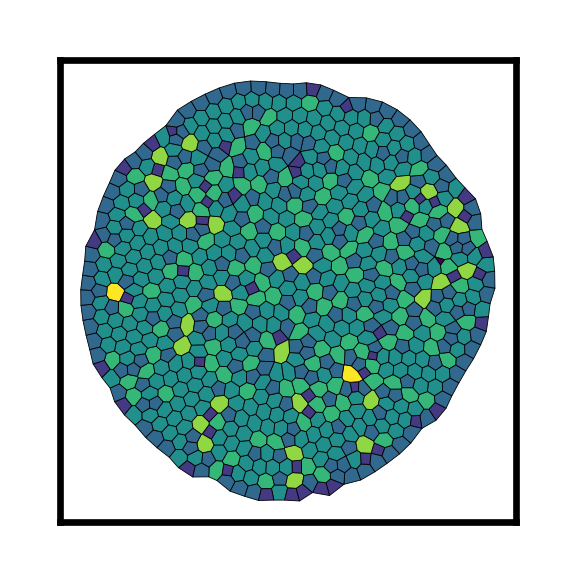

In [392]:
plot_tissue(tissue,color_by='num_sides')

In [393]:
tissue.edge_df
# export as csv 
tissue.edge_df.to_csv('tissue_edges_internal_T1_1.csv',index=False)

tissue.face_df
# export as csv 
tissue.face_df.to_csv('tissue_face_internal_T1_1.csv',index=False)

tissue.vert_df
# export as csv 
tissue.vert_df.to_csv('tissue_vert_internal_T1_1.csv',index=False)

<a name='4-2.2'></a>
### 4.2.2 - Internal to Boundary T1 Rearrangements

We use for this case ```t1_type='interior_to_boundary_t1'```. This case still considers internal halfedges but one of the vertex end points of the haldedge is a boundary vertex.

In [437]:
t1_int_to_bound_able_dbonds = t1_able_edges(tissue,t1_type='interior_to_boundary_t1')
t1_int_to_bound_able_dbonds

array([  26,   27,   76,  131,  132,  166,  294,  309,  320,  322,  339,
        343,  352,  391,  393,  435,  437,  440,  443,  448,  458,  461,
        470,  473,  483,  484,  486,  537,  564,  570,  576,  600,  618,
        633,  646,  648,  651,  654,  696,  699,  714,  727,  730,  910,
        912,  966,  973,  975,  991,  992,  995,  999, 1008, 1012, 1220,
       1369, 1371, 1416, 1472, 1473, 1530, 1537, 1561, 1563, 1646, 1678,
       1715, 1760, 1766, 1767, 1782, 1783, 1807, 1809, 1814, 1819, 1946,
       2163, 2165, 2168, 2172, 2192, 2198, 2561, 2591, 2610, 2627, 2629,
       2638, 2639, 2656, 2664, 2681, 2701, 2707, 2723, 2724, 2749, 2832,
       2835, 2855, 2924, 2926, 3005, 3024, 3025, 3048, 3051, 3056, 3058,
       3070, 3189, 3206, 3658, 3671, 3673, 3726, 3736, 3761, 3763, 3764,
       3788, 3790, 4260, 4570, 4571, 4582, 4583, 4584, 4585, 4620, 4621,
       4624, 4625, 4638, 4639, 4648, 4649, 4812, 4813, 5545, 5546, 5610,
       5611, 5615, 5616], dtype=int64)

In [440]:
edge_ID_list = rng.choice(t1_int_to_bound_able_dbonds,size=5,replace=False)

edge_ID_list

array([2924,  393, 1416,  576,  651], dtype=int64)

In [441]:
t1type = 1 # 1 for interior_to_boundary_t1

for edge_id in edge_ID_list:
    generic_t1_rearrangement(tissue,edge_id,t1type)
    
energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)

energy_solver.find_energy_min()

The cell with ID: 14 was collapsed.
The cell with ID: 53 was collapsed.
The cell with ID: 99 was collapsed.
The cell with ID: 234 was collapsed.
The cell with ID: 255 was collapsed.
The cell with ID: 261 was collapsed.
The cell with ID: 263 was collapsed.
The cell with ID: 277 was collapsed.
The cell with ID: 294 was collapsed.
The cell with ID: 301 was collapsed.
The cell with ID: 365 was collapsed.
The cell with ID: 435 was collapsed.
The cell with ID: 438 was collapsed.
The cell with ID: 450 was collapsed.
The cell with ID: 453 was collapsed.
The cell with ID: 489 was collapsed.
The cell with ID: 611 was collapsed.
The edge with ID: 3207 was collapsed.
The edge with ID: 4566 was collapsed.
The edge with ID: 5590 was collapsed.
The edge with ID: 1742 was collapsed.
The edge with ID: 2834 was collapsed.
The edge with ID: 4542 was collapsed.
The edge with ID: 2630 was collapsed.
The edge with ID: 3745 was collapsed.
The edge with ID: 1417 was collapsed.
The edge with ID: 1765 was colla

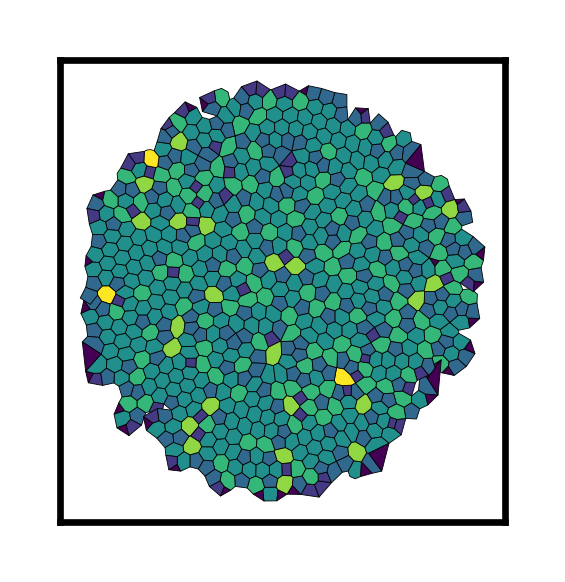

In [442]:
plot_tissue(tissue,color_by='num_sides')

In [443]:
tissue.edge_df
# export as csv 
tissue.edge_df.to_csv('tissue_edges_internalb_T1_1.csv',index=False)

tissue.face_df
# export as csv 
tissue.face_df.to_csv('tissue_face_internalb_T1_1.csv',index=False)

tissue.vert_df
# export as csv 
tissue.vert_df.to_csv('tissue_vert_internalb_T1_1.csv',index=False)

<a name='4-2.3'></a>
### 4.2.1 - Boundary T1 Rearrangements

We use for this case ```t1_type='boundary_t1'```. The latter case considers boundary halfedges with the caveat that at least one of the vertex end points should be also an endpoint of some other internal halfedge.

In [449]:
# tissue = convert_to_tissue_class(generate_honeycomb_patch,Lx,Ly,rotation=orientation) # Let's reset the tissue so it doesn't get too cluttered. 

t1_boundary_able_dbonds = t1_able_edges(tissue,t1_type='boundary_t1')

edge_ID_list = rng.choice(t1_boundary_able_dbonds,size=8,replace=False)

edge_ID_list

array([5210, 5535, 5086, 5596, 5621, 5331, 1817, 1296], dtype=int64)

In [450]:
t1type = 2 # 2 for boundary_t1

for edge_id in edge_ID_list:
    generic_t1_rearrangement(tissue,edge_id,t1type)
    
energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)

energy_solver.find_energy_min()

The edge with ID: 5675 was collapsed.


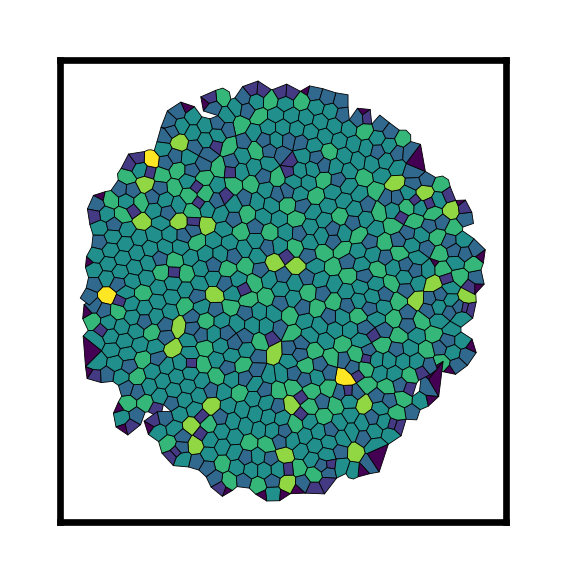

In [451]:
plot_tissue(tissue,color_by='num_sides')

In [452]:
tissue.edge_df
# export as csv 
tissue.edge_df.to_csv('tissue_edges_boundary_T1_1.csv',index=False)

tissue.face_df
# export as csv 
tissue.face_df.to_csv('tissue_face_boundary_T1_1.csv',index=False)

tissue.vert_df
# export as csv 
tissue.vert_df.to_csv('tissue_vert_boundary_T1_1.csv',index=False)

<a name='4-3'></a>
### 4.3 - Cell Collapse

This move takes a given cell within the tissue and removes it by collapsing into a vertex. In doing so all the surrounding vertices lose one of their sides and a new vertex withing the tissue is created. This can be done with the function ```delete_cell``` which takes a ```Tissue``` object as a argument as well as the ndex ID of the face to be removed.

In [329]:
# # Let's use an untouched tissue configuration
# tissue = convert_to_tissue_class(generate_honeycomb_patch,Lx,Ly,rotation=orientation)

Let's pick an internal cell. This is a cell completely surrounded by other cells. There are multiple ways of finding the internal cells but we do so by first by finding the boundary cells.

In [453]:
boundary_faces_IDs = tissue.edge_df.loc[tissue.edge_df['is_interior'] == False,'dbond_face'].unique()

# We find elements of the face index list that are not present in boundary_faces_IDs
interior_faces_IDs = np.setdiff1d(tissue.face_df['id'].values,boundary_faces_IDs)

interior_faces_IDs



array([  0,   1,   2,   3,   4,   5,   6,  15,  19,  20,  21,  22,  23,
        24,  25,  26,  27,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  51,
        55,  56,  61,  62,  63,  64,  65,  67,  68,  69,  71,  72,  78,
        82,  84,  87,  88,  91,  92,  93,  94, 101, 102, 107, 112, 115,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 154, 155, 156, 157, 158, 160, 164, 165, 168, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 205, 206, 208, 209, 210, 211, 212, 213, 214,
       215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227,
       228, 232, 233, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 258, 264, 265, 266, 26

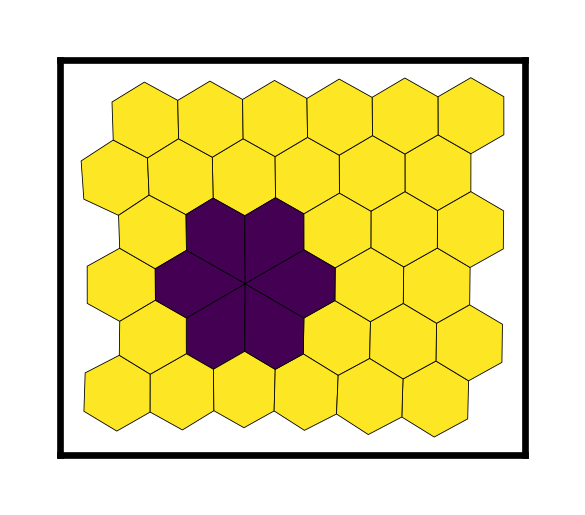

In [331]:
face_id = 24
delete_cell(tissue,face_id)

energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)

energy_solver.find_energy_min()

plot_tissue(tissue,color_by='num_sides')

In [332]:
tissue.edge_df
# export as csv 
tissue.edge_df.to_csv('tissue_edges_simple_cell_collapse1.csv',index=False)

tissue.face_df
# export as csv 
tissue.face_df.to_csv('tissue_face_simple_cell_collapse1.csv',index=False)

tissue.vert_df
# export as csv 
tissue.vert_df.to_csv('tissue_vert_simple_cell_collapse1.csv',index=False)

In [333]:
boundary_faces_IDs = tissue.edge_df.loc[tissue.edge_df['is_interior'] == False,'dbond_face'].unique()

# We find elements of the face index list that are not present in boundary_faces_IDs
interior_faces_IDs = np.setdiff1d(tissue.face_df['id'].values,boundary_faces_IDs)

interior_faces_IDs

array([ 4,  5,  6,  8, 10, 14, 18, 23, 25, 26, 27, 28, 30, 31, 34])

In [454]:
face_id = rng.choice(interior_faces_IDs)
delete_cell(tissue,face_id)

energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)

energy_solver.find_energy_min()

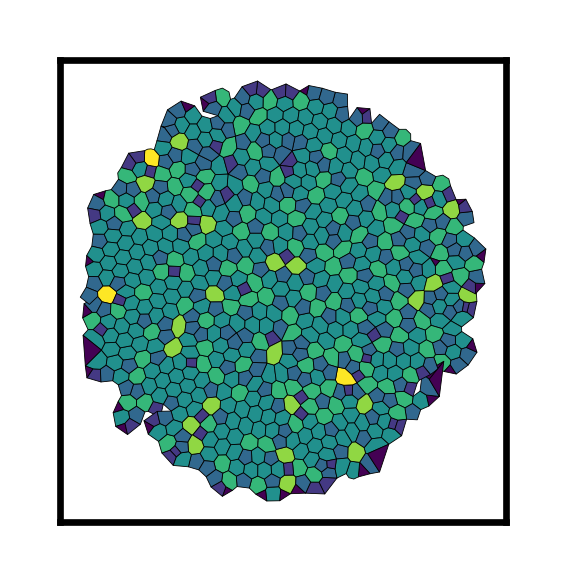

In [455]:
plot_tissue(tissue,color_by='num_sides')

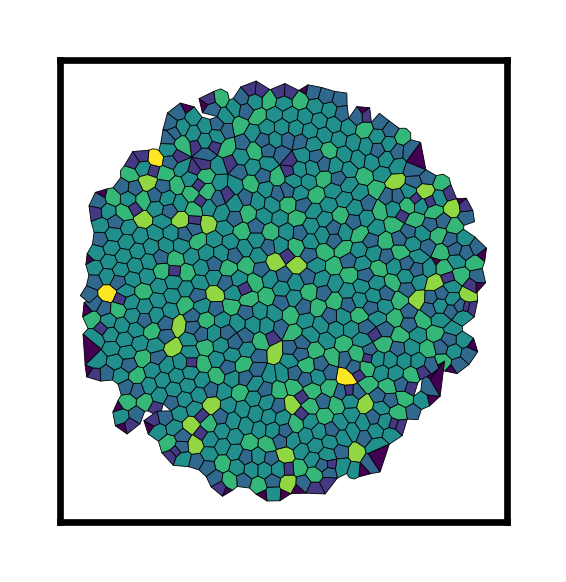

In [457]:
boundary_faces_IDs = tissue.edge_df.loc[tissue.edge_df['is_interior'] == False,'dbond_face'].unique()

# We find elements of the face index list that are not present in boundary_faces_IDs
interior_faces_IDs = np.setdiff1d(tissue.face_df['id'].values,boundary_faces_IDs)

interior_faces_IDs

face_id = rng.choice(interior_faces_IDs)
delete_cell(tissue,face_id)

energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)

energy_solver.find_energy_min()

plot_tissue(tissue,color_by='num_sides')


In [458]:
tissue.edge_df
# export as csv 
tissue.edge_df.to_csv('tissue_edges_rng_cell_collapse2_1.csv',index=False)

tissue.face_df
# export as csv 
tissue.face_df.to_csv('tissue_face_rng_cell_collapse2_1.csv',index=False)

tissue.vert_df
# export as csv 
tissue.vert_df.to_csv('tissue_vert_rng_cell_collapse2_1.csv',index=False)

Boundary cells can elso be removed although that functionality for the moment only removes the cell without collapsing the edges of the neighboring cells. We see an example below. This will be extended to a more general case where the edges of the surrounding cells will be collapsed as well. 

In [35]:
face_id = 7

delete_cell(tissue,face_id,remove_boundary=True)

energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)

energy_solver.find_energy_min()

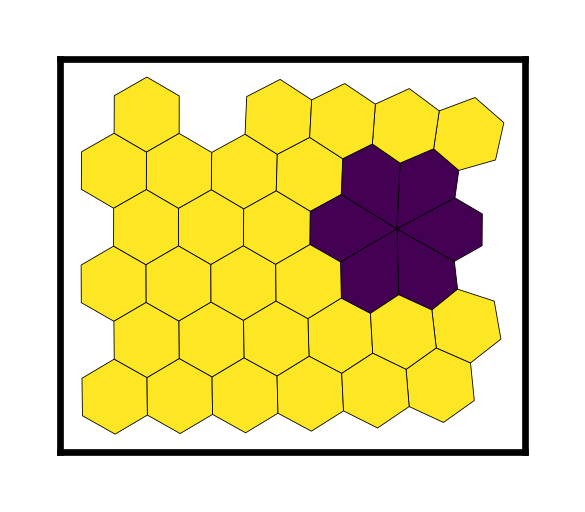

In [36]:
plot_tissue(tissue,color_by='num_sides')

Although not fully present in the list of topological moves, this is a perfect opportunity to take advantage of the halfedge data structure. Let's remove again the previous boundary face, but this time we'll make sure that the surrounding faces lose a side in the process. This can be done as a two steps process. First, we'll reset the tissue.

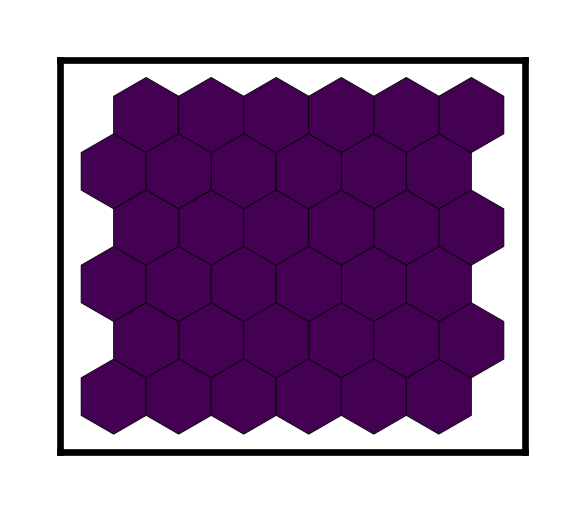

In [275]:
# tissue = convert_to_tissue_class(generate_honeycomb_patch,Lx,Ly,rotation=orientation)
# plot_tissue(tissue,color_by='num_sides')

We find first the list of halfedges associated with the cell with index face_id. This can be done with the convenient ```pd.Series``` object ```tissue.face_dbonds```.

In [459]:
face_id = rng.choice(boundary_faces_IDs)
edge_id = rng.choice(tissue.face_dbonds.loc[face_id])

halfedge_list = tissue.face_dbonds.loc[face_id]

halfedge_list

array([2854, 2855, 5091, 4584, 2859], dtype=int64)

We find now the conjugate edges of each halfedge in ```halfedge_list```. We will call that list ```conj_halfedge_list```. This can be done with a simple query.

In [460]:
conj_halfedge_list = tissue.edge_df.loc[halfedge_list,'conj_dbond'].values
conj_halfedge_list

array([2898, 2835,   -1, 4585, 2841], dtype=int64)

The -1 values are the default values for the sides exposed to the boundary. We can easily get rid of those with ```np.setdiff1d```.

In [461]:
conj_halfedge_list = np.setdiff1d(conj_halfedge_list,[-1])
conj_halfedge_list

array([2835, 2841, 2898, 4585], dtype=int64)

We now remove that cell as before and will inmediately collapse the conjugate halfedges of the surrounding faces.

In [462]:
delete_cell(tissue,face_id,remove_boundary=True)

for edge_id in conj_halfedge_list:
    collapse_edge(tissue,edge_id)

energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)

energy_solver.find_energy_min()

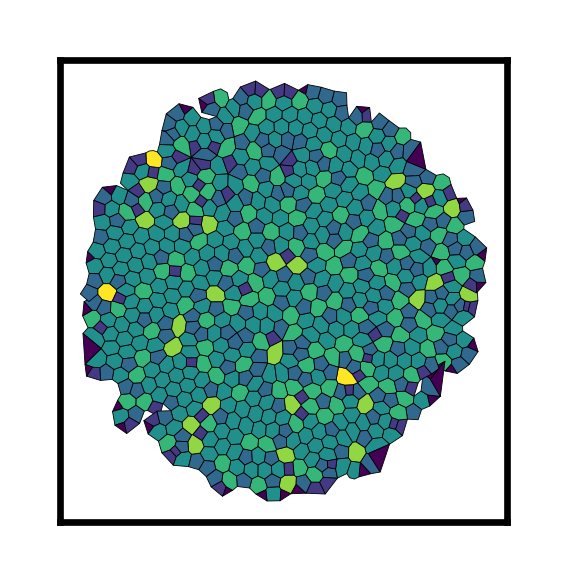

In [463]:
plot_tissue(tissue,color_by='num_sides')

In [464]:
tissue.edge_df
# export as csv 
tissue.edge_df.to_csv('tissue_edges_bound_cell_collapse2_1.csv',index=False)

tissue.face_df
# export as csv 
tissue.face_df.to_csv('tissue_face_bound_cell_collapse2_1.csv',index=False)

tissue.vert_df
# export as csv 
tissue.vert_df.to_csv('tissue_vert_boud_cell_collapse2_1.csv',index=False)

The previous example shows that we can easily generate more complex topological changes by finding a suitable was of composing the topological "building blocks" that we have at our disposal.

<a name='4-4'></a>
### 4.4 - Cell Divisions

We conclude by showing how we can perform cell divisions. We use the function ```divide_cell``` which takes a ```Tissue``` object as a argument as well as the index ID of the face to be divided.

In [152]:
# tissue = convert_to_tissue_class(generate_honeycomb_patch,Lx,Ly,rotation=orientation)

In [467]:
face_id = rng.choice(interior_faces_IDs)

divide_cell(tissue,face_id)

energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)

energy_solver.find_energy_min()

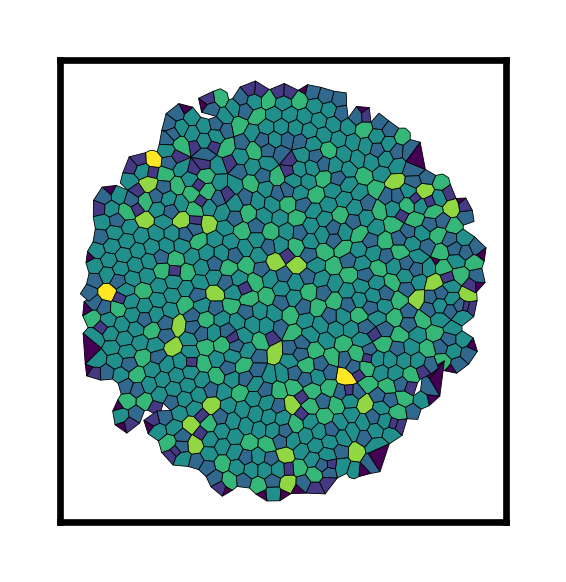

In [466]:
plot_tissue(tissue,color_by='num_sides')

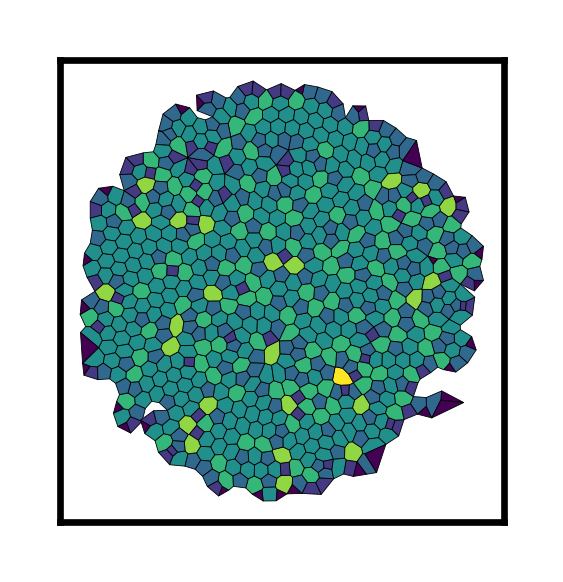

In [469]:
round_off_boundary(tissue)

energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)

energy_solver.find_energy_min()

plot_tissue(tissue,color_by='num_sides')

In [470]:
tissue.edge_df
# export as csv 
tissue.edge_df.to_csv('tissue_edges_cell_div_1.csv',index=False)

tissue.face_df
# export as csv 
tissue.face_df.to_csv('tissue_face_cell_div_1.csv',index=False)

tissue.vert_df
# export as csv 
tissue.vert_df.to_csv('tissue_vert_cell_div_1.csv',index=False)

It also works for boundary faces!

In [471]:
face_id = rng.choice(boundary_faces_IDs)

divide_cell(tissue,face_id)

energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)

energy_solver.find_energy_min()

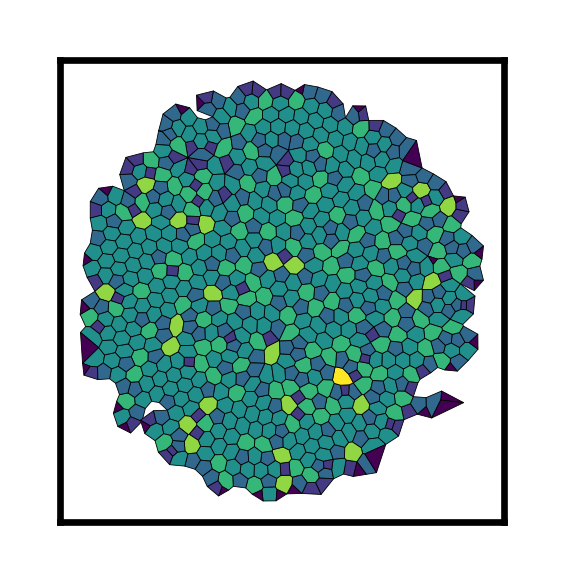

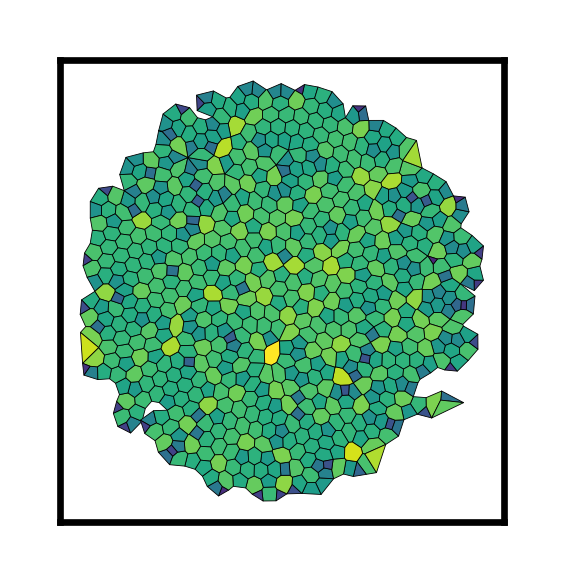

In [472]:
plot_tissue(tissue,color_by='num_sides')

plot_tissue(tissue,color_by='area')

If desired, the axis of division can be specified by passing the axis angle tot the ```axis_ang``` parameter.

In [485]:
face_id = rng.choice(interior_faces_IDs)

div_angle = 3*pi/4

divide_cell(tissue,face_id,division_angle=div_angle)

energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)

energy_solver.find_energy_min()

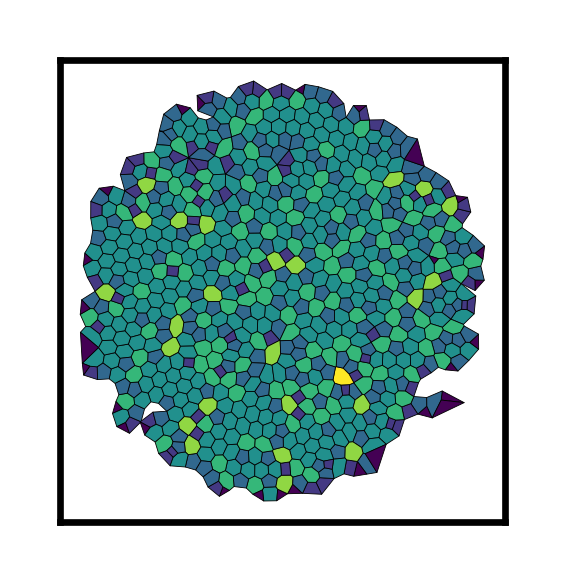

In [486]:
plot_tissue(tissue,color_by='num_sides')

In [477]:
tissue.edge_df
# export as csv 
tissue.edge_df.to_csv('tissue_edges_cell_div_complex_1.csv',index=False)

tissue.face_df
# export as csv 
tissue.face_df.to_csv('tissue_face_cell_div_complex_1.csv',index=False)

tissue.vert_df
# export as csv 
tissue.vert_df.to_csv('tissue_vert_cell_div_complex_1.csv',index=False)

In [488]:
face_id = rng.choice(boundary_faces_IDs)

div_angle = 3*pi/4

divide_cell(tissue,face_id,division_angle=div_angle)

energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)

energy_solver.find_energy_min()

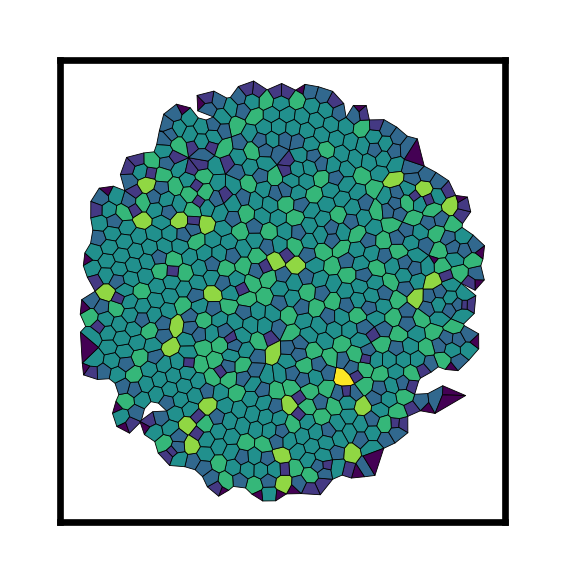

In [489]:
plot_tissue(tissue,color_by='num_sides')

In [491]:
#hexogonal cells counting
tissue.face_df['num_sides'].value_counts()

#pick hexogonal cells and give their id
tissue.face_df.loc[tissue.face_df['num_sides'] == 6,'id'].values






array([  0,   1,   2,   3,   4,   8,  15,  17,  20,  21,  22,  26,  27,
        30,  31,  32,  34,  41,  42,  43,  44,  45,  46,  47,  52,  55,
        59,  60,  64,  69,  72,  78,  82,  86,  87,  91,  93, 123, 124,
       125, 126, 127, 130, 132, 135, 136, 137, 140, 146, 152, 155, 160,
       164, 165, 168, 171, 172, 173, 174, 176, 177, 181, 182, 186, 187,
       188, 189, 190, 191, 194, 197, 199, 201, 208, 209, 210, 211, 213,
       215, 218, 219, 221, 225, 228, 239, 243, 247, 248, 249, 250, 252,
       253, 254, 258, 260, 264, 268, 270, 271, 272, 273, 274, 278, 279,
       280, 282, 287, 292, 297, 300, 306, 307, 310, 311, 313, 315, 318,
       319, 324, 325, 328, 329, 330, 333, 335, 336, 338, 342, 345, 352,
       353, 355, 370, 371, 374, 375, 376, 381, 382, 385, 386, 387, 388,
       389, 390, 391, 392, 393, 395, 396, 401, 402, 407, 409, 411, 412,
       414, 416, 417, 421, 423, 425, 428, 441, 446, 455, 456, 462, 464,
       467, 470, 471, 478, 481, 482, 487, 488, 490, 491, 493, 49

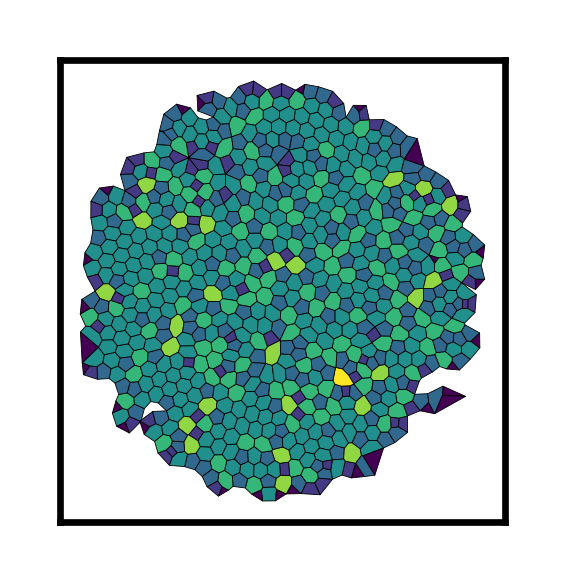

In [493]:
# Let's try to pick the hexagonal cells and divide them
hex_cells = tissue.face_df.loc[tissue.face_df['num_sides'] == 6,'id'].values

face_id = rng.choice(hex_cells)

div_angle = 3*pi/4

divide_cell(tissue,face_id,division_angle=div_angle)

energy_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient,
                                minimization_method='CG',gtol=1e-05)

energy_solver.find_energy_min()

plot_tissue(tissue,color_by='num_sides')



In [496]:
#hexogonal cells counting
tissue.face_df['num_sides'].value_counts()



6    279
5    182
7    124
4     70
3     29
8     25
9      1
Name: num_sides, dtype: int64

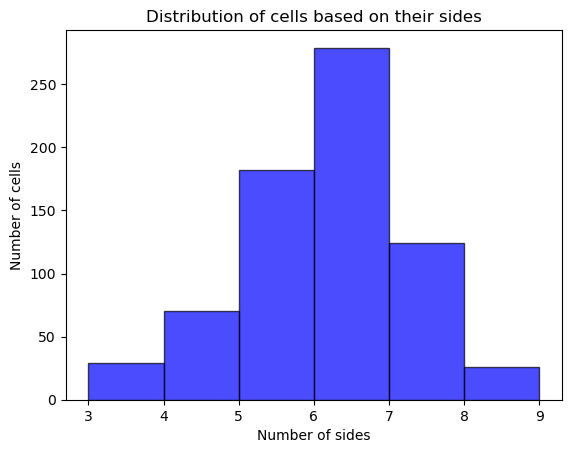

In [498]:
#plot distribution of cells based on their sides
plt.hist(tissue.face_df['num_sides'],bins=range(3,10),color='blue',edgecolor='black',alpha=0.7)
plt.xlabel('Number of sides')
plt.ylabel('Number of cells')
plt.title('Distribution of cells based on their sides')
plt.show()


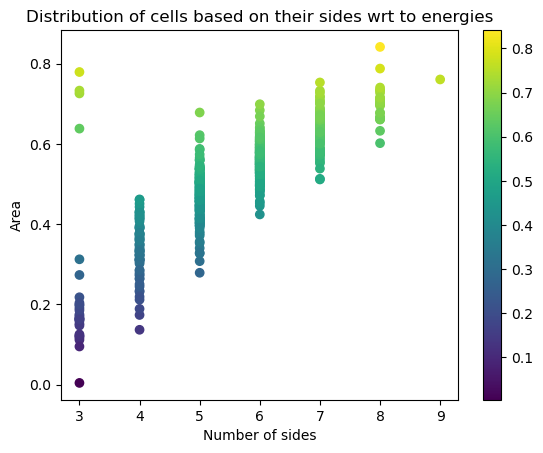

In [499]:
#plot distribution of cells based on their sides wrt to energies
plt.scatter(tissue.face_df['num_sides'],tissue.face_df['area'],c=tissue.face_df['area'],cmap='viridis')
plt.xlabel('Number of sides')
plt.ylabel('Area')
plt.title('Distribution of cells based on their sides wrt to energies')
plt.colorbar()
plt.show()

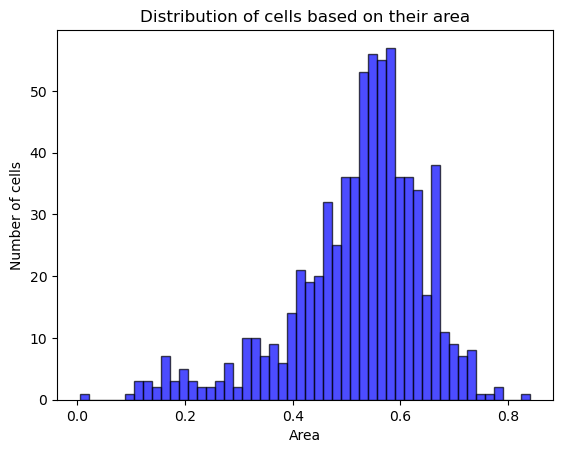

In [504]:
#plot energy distribution of cells
plt.hist(tissue.face_df['area'],bins=50,color='blue',edgecolor='black',alpha=0.7)
plt.xlabel('Area')
plt.ylabel('Number of cells')
plt.title('Distribution of cells based on their area')
plt.show()



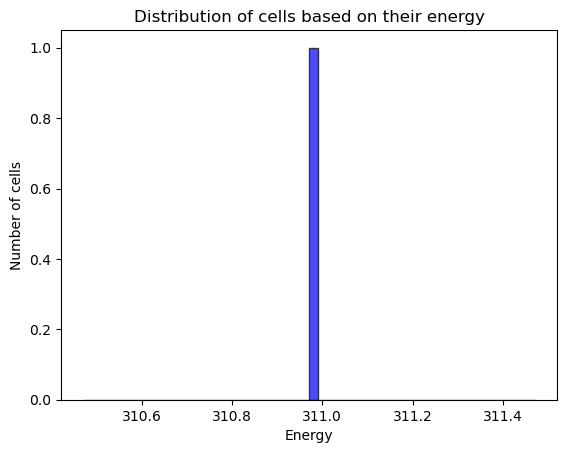

In [505]:
#using tissue energy function calculate the energy distribution among faces based on sides
face_energy = tissue_energy(tissue)
face_energy

#plot energy distribution of cells
plt.hist(face_energy,bins=50,color='blue',edgecolor='black',alpha=0.7)
plt.xlabel('Energy')
plt.ylabel('Number of cells')
plt.title('Distribution of cells based on their energy')
plt.show()


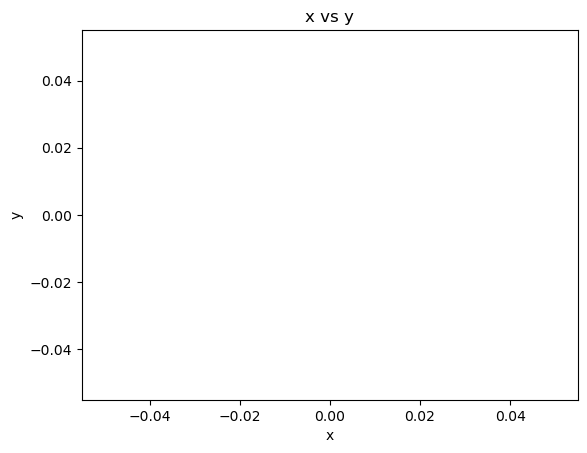

In [510]:
if 'x' in tissue.edge_df.columns:
    x = tissue.edge_df.loc[tissue.edge_df['is_interior'], 'x'].values
else:
    x = []
    
if 'y' in tissue.edge_df.columns:
    y = tissue.edge_df.loc[tissue.edge_df['is_interior'], 'y'].values
else:
    y = []
    
#plot x vs y
plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('x vs y')
plt.show()



In [497]:
#pick hexogonal cells and give their id
tissue.face_df.loc[tissue.face_df['num_sides'] == 6,'id'].values

array([  0,   1,   2,   3,   4,   8,  15,  17,  20,  21,  22,  26,  27,
        30,  31,  32,  34,  41,  42,  43,  44,  45,  46,  47,  52,  55,
        59,  60,  64,  69,  72,  78,  82,  86,  87,  91,  93, 123, 124,
       125, 126, 127, 130, 132, 135, 136, 137, 140, 146, 152, 155, 160,
       164, 165, 168, 171, 172, 173, 174, 176, 177, 181, 182, 186, 187,
       188, 189, 190, 191, 194, 197, 199, 201, 208, 209, 210, 211, 213,
       215, 218, 219, 221, 225, 228, 239, 243, 247, 248, 249, 250, 252,
       253, 254, 258, 260, 264, 268, 270, 271, 272, 273, 274, 278, 279,
       280, 282, 287, 292, 297, 300, 306, 307, 310, 311, 313, 315, 318,
       319, 324, 325, 328, 329, 330, 333, 335, 336, 338, 342, 345, 352,
       353, 355, 370, 371, 374, 375, 376, 381, 382, 385, 386, 387, 388,
       389, 390, 391, 392, 393, 395, 396, 401, 402, 407, 409, 411, 412,
       414, 416, 417, 421, 423, 425, 428, 441, 446, 455, 456, 462, 464,
       467, 470, 471, 478, 481, 482, 487, 488, 490, 491, 493, 49

In [482]:
#get the value of strain in each edge
def edge_strain(tissue, edge_id):
    # implementation of the edge_strain function
    pass

#plot the strain of each edge vs the length of the edge with their respective colors
 
def plot_edge_strain(tissue):
    # implementation of the plot_edge_strain function
    pass   

#plot the strain of each edge vs the length of the edge
plot_edge_strain(tissue)
import matplotlib.pyplot as plt

# Assuming you have the strain values and edge positions stored in arrays
strain_values = #extract "line tension" from tissue_edges_cell_div_complex1.csv file 
edge_positions = [...]  # Array of edge positions

# Plotting the strain values vs edge positions
plt.plot(edge_positions, strain_values, marker='o', linestyle='-', color='blue')
plt.xlabel('Edge Positions')
plt.ylabel('Strain Values')
plt.title('Strain Values vs Edge Positions')
plt.grid(True)
plt.show()
